In [1]:
import csv
import sys
import math
import platform
import os.path
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from datetime import timedelta

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
class Ponto:
    """A class that represents a certain point in the map at certain time"""
    def __init__(self,pointData):
        self.pointData = pointData

    def __str__(self):
        return self.pointData['Hora'] + " " + str(self.pointData['Coord'])

In [4]:
#  Lista de cores a serem utilizadas no mapa
listaCores = ['#d1432a', '#34f32a', '#ff3456']
#  dictionary com os pontos referentes a cada id
pontos = {}
#  dictionary com os intervalos de tempos entre os pontos para cada id
timeGaps = {}
#  dictionary os intervalos de distancias entre os pontos para cada id
coordGaps = {}
#  dict em que cada chave contem uma lista com os indices onde as separações devem ser feitas
separator = {}
#  lista com todos intervalos de tempo entre os pontos
allTimeGaps = []
timeGapsDiscrete = []
#  lista com todos intervalos de distancia entre os pontos
allCoordGaps = []
coordGapsDiscrete = []
#  listas dos pontos iniciais e finais de cada viagem
orig = []
dest = []

travels = []
keys = [] 

#  limites
# limitDist = 25
limitDist = 50
# limitDist = 350
# limitTempo = timedelta(seconds=15)
limitTempo = timedelta(seconds=18)
# limitTempo = timedelta(seconds=38)

In [5]:
if platform.system() == 'Linux':
    path = '/home/tulionpl/Repos/Pesquisa'
elif platform.system() == 'Windows':
    path = 'C:/Users/Tulio/Documents/Code/Pesquisa'
else:
    path = '/Users/tuliopolido/Documents/Pesquisa'

In [6]:
def convertHaversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r * 1000

In [7]:
def distDoisPontos(i, j, pontos):
    """Função para calcular a distância entre dois pontos"""

    dist = 0

    for k in range(i, j):
        point1 = pontos[k]
        point2 = pontos[k+1]

        pointCoord1 = point1.pointData['Coord']
        pointCoord2 = point2.pointData['Coord']

        dist += convertHaversine(pointCoord1[0],
                                 pointCoord1[1], pointCoord2[0], pointCoord2[1])

    return dist

In [8]:
def tempoDoisPontos(i, j, pontos):
    """Função para calcular o tempo entre dois pontos

    Argumentos:
    i -- Posição do primeiro ponto
    j -- Posição do segundo ponto
    pontos -- lista de pontos
    """

    ponto1 = pontos[i]
    ponto2 = pontos[j]
    pointTime = ponto1.pointData['Hora']
    pointTime = datetime.strptime(pointTime, '%Y-%m-%d %H:%M:%S')
    pointTime2 = ponto2.pointData['Hora']
    pointTime2 = datetime.strptime(pointTime2, '%Y-%m-%d %H:%M:%S')

    tempo = pointTime2-pointTime

    return tempo

In [9]:

def lerRoma():
    """Função para ler a base de dados com os valores ja calculados"""

    print('Lendo dados...')
    with open(path+'/data/timeGaps.txt', 'r') as file:
        allTimeGaps = list(map(float, file.readlines())).copy()

    with open(path+'/data/coordGaps.txt', 'r') as file:
        allCoordGaps = list(map(float, file.readlines())).copy()

    with open(path+'/data/keys.txt', 'r') as file:
        keys = list(map(str, file.readlines())).copy()
        keys = list(map(str.strip, keys)).copy()

    timeGapsDiscrete = list(map(int, allTimeGaps)).copy()
    coordGapsDiscrete = list(map(int, allCoordGaps)).copy()

    #  le arquivo com a lista de sequencia de ids
    with open(path+'/data/ids.txt', 'r') as file:
        ids = list(map(str, file.readlines())).copy()
        ids = list(map(str.strip, ids)).copy()

    #  le arquivo com a lista de sequencia de coordenadas
    with open(path+'/data/coordenadas.txt', 'r') as file:
        crds = list(map(str, file.readlines())).copy()
        crds = list(map(str.strip, crds)).copy()
        crds = list(map(eval, crds)).copy()

    #  le arquivo com a lista de sequencia de horas
    with open(path+'/data/hora.txt', 'r') as file:
        hrs = list(map(str, file.readlines())).copy()
        hrs = list(map(str.strip, hrs)).copy()

    #  inicializa o dict de pontos com uma lista para cada id
    for id in ids:
        pontos[id] = []

    for i in range(0, len(hrs)):
        pnt = {}
        pnt['Hora'] = hrs[i]
        pnt['Coord'] = crds[i]
        newInstance = Ponto(pnt)
        pontos[ids[i]].append(newInstance)

    print('Pronto!')

    return allTimeGaps, allCoordGaps, timeGapsDiscrete, coordGapsDiscrete, keys, pontos
allTimeGaps, allCoordGaps, timeGapsDiscrete, coordGapsDiscrete, keys, pontos = lerRoma()

Lendo dados...
Pronto!


In [10]:
def stayPoint_Detection():
    """Algoritmo para detecção de paradas"""

    #print('\nColetando pontos de parada...')
    for key in keys:
        separator[key] = []
        numPontos = len(pontos[key])

        i = 0
        while i < numPontos-1:
            dist = distDoisPontos(i, i+1, pontos[key])

            if dist > limitDist:
                tempo = tempoDoisPontos(i, i+1, pontos[key])

                if tempo > limitTempo:
                    separator[key].append(i)
            i += 1

        separator[key].append(numPontos-1)  # Adiciona ponto final
    #print('Pronto!')
limitDist = 25
limitTempo = timedelta(seconds=15)
stayPoint_Detection()

In [11]:
def granuralidade():
    fig, ax = plt.subplots()
    # axIns = ax.inset_axes([0.39, 0.39, 0.6, 0.6])

    # index = np.arange(0,56,5)
    # index = [int(i) for i in index]

    # ax.set_xticks(index)

    plt.hist(allTimeGaps, bins=range(0,31,5), edgecolor='black',align='mid',rwidth=1.5)
    # axIns.hist(allTimeGapsKmH, bins=range(0,251,25), edgecolor='black',align='mid')

    #plota linha com média
    plt.axvline(np.mean(allTimeGaps), color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.mean(allTimeGaps)*2.1, max_ylim*0.5, 'Média: {:.1f}s'.format(np.mean(allTimeGaps)))

    # axIns.set_title("Em Km/H",x=0.7,y=0.8)
    plt.title('Granuralidade(Roma)')  
    plt.xlabel('Tamanho do intervalo em segundos')
    plt.ylabel('Quantidade de intervalos')
    plt.savefig(path+'/img/granuralidade_Roma.png', dpi=300, transparent=False, facecolor='white')

    plt.show()
    return np.mean(allTimeGaps)
    

In [12]:
#granuralidade()

In [13]:
def posOD():
    posOrigem = {}
    posDestino = {}
    posOrigem['lat'] = []
    posOrigem['long'] = []
    posDestino['lat'] = []
    posDestino['long'] = []
    tripArrays = []

    df = pd.read_csv(path+"/data/roma_calibrated_sorted.csv")
    df = df.sort_values(['id', 'time'])

    for key in keys:
        df_id = df.loc[df['id'] == int(key)]
        for stop in separator[key]:
            if len(df_id) > 5:
                inicio = df_id.index[stop-1]
                fim = df_id.index[stop]

                timeInicio = datetime.strptime(df_id['time'][inicio],'%Y-%m-%d %H:%M:%S')
                horario1Inicio = datetime.strptime("2014-02-04 00:00:00",'%Y-%m-%d %H:%M:%S')
                horario1Fim = datetime.strptime("2014-02-04 05:59:59",'%Y-%m-%d %H:%M:%S')
                horario2Inicio = datetime.strptime("2014-02-04 06:00:00",'%Y-%m-%d %H:%M:%S')
                horario2Fim = datetime.strptime("2014-02-04 11:59:59",'%Y-%m-%d %H:%M:%S')
                horario3Inicio = datetime.strptime("2014-02-04 12:00:00",'%Y-%m-%d %H:%M:%S')
                horario3Fim = datetime.strptime("2014-02-04 17:59:59",'%Y-%m-%d %H:%M:%S')
                horario4Inicio = datetime.strptime("2014-02-04 18:00:00",'%Y-%m-%d %H:%M:%S')
                horario4Fim = datetime.strptime("2014-02-04 23:59:59",'%Y-%m-%d %H:%M:%S')

                # horarioInicio = horario1Inicio
                # horariofim = horario1Fim
                # horarioInicio = horario2Inicio
                # horariofim = horario2Fim
                # horarioInicio = horario3Inicio
                # horariofim = horario3Fim
                horarioInicio = horario4Inicio
                horariofim = horario4Fim

                if timeInicio >= horarioInicio and timeInicio <= horariofim:
                # if True:
                    x = df_id['lat_y'][inicio]
                    y = df_id['long_x'][inicio]
                    posOrigem['lat'].append(x)
                    posOrigem['long'].append(y)

                    x = df_id['lat_y'][fim]
                    y = df_id['long_x'][fim]
                    posDestino['lat'].append(x)
                    posDestino['long'].append(y)
            
    return posOrigem,posDestino

posOrigem,posDestino = posOD()

In [ ]:
def heatmap():
    ### Plota um heatmap dos destinos das trips
    x = []
    y = []

    for i in range(len(posDestino['long'])):
        if posDestino['long'][i] > 12.2 and posDestino['long'][i] < 12.7 and\
            posDestino['lat'][i] > 41.7 and posDestino['lat'][i] < 42.1:
            x.append(posDestino['long'][i])
            y.append(posDestino['lat'][i])

    x = np.array(x)
    y = np.array(y)

    print(x.min(), x.max(), y.min(), y.max())
    
    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    fig, ax = plt.subplots()

    # alpha=0.5 will make the plots semitransparent
    plot = ax.contourf(xi, yi, zi.reshape(xi.shape), alpha=0.4)
    fig.colorbar(plot,label="Nº de pontos de destino")

    ax.set_title('Heatmap de pontos de GPS 00h-06h (Roma)')
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # you can also overlay your soccer field 
    im = plt.imread(path+'/img/backmap_all_Roma1.png')
    ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    # plt.savefig(path+"/img/mapaCalor_Romab.png", dpi=300, transparent=False, facecolor='white')
    plt.show()
heatmap()

In [ ]:
### Plota um heatmap das origens das trips

BBox = (min(posOrigem['long']),max(posOrigem['long']),min(posOrigem['lat']),max(posOrigem['lat'])) #limites laterais do mapa
print(BBox)
ruh_m = plt.imread(path+'/img/backmap_all_Roma2.png') #mapa a ser usado de fundo

fig, ax = plt.subplots()
ax.scatter(posOrigem['long'], posOrigem['lat'], zorder=1, alpha=1, c='#d1432a', s=0.5)
ax.legend(['Ponto de Origem'])
ax.set_title('Scatter Map Roma - Origem')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.imshow(ruh_m,zorder=0, extent=BBox, aspect='equal')

# plt.savefig(path+"/img/mapaCalorOrigem_Roma.png", dpi=300, transparent=False, facecolor='white')
plt.show()

In [ ]:
### Plota um heatmap dos destinos das trips

BBox = (min(posDestino['long']),max(posDestino['long']),min(posDestino['lat']),max(posDestino['lat'])) #limites laterais do mapa
ruh_m = plt.imread(path+'/img/backmap_all_Roma2.png') #mapa a ser usado de fundo

fig, ax = plt.subplots()
ax.scatter(posDestino['long'], posDestino['lat'], zorder=1, alpha=1, c='#d1432a', s=0.5)
ax.legend(['Ponto de Destino'])
ax.set_title('Scatter Map Roma - Destino')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.imshow(ruh_m,zorder=0, extent=BBox, aspect='equal')

# plt.savefig(path+"/img/mapaCalorDestino_Roma.png", dpi=300, transparent=False, facecolor='white')
plt.show()

In [ ]:
### Plota um heatmap dos destinos das trips

x = np.array(posDestino['long'])
y = np.array(posDestino['lat'])

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plot = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, alpha=0.4)
fig.colorbar(plot,label="Nº de pontos de destino")

ax.set_title('Heatmap de pontos de destino(Roma e região)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmap_all_Roma2.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
# plt.savefig(path+"/img/mapaCalorDestino_Roma2b.png", dpi=300, transparent=False, facecolor='white')


12.2269280329202 12.623845 41.7048059234998 41.9987034458185


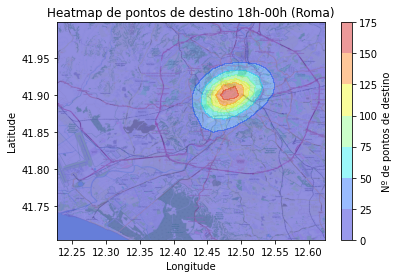

In [19]:
### Plota um heatmap dos destinos das trips
x = []
y = []



for i in range(len(posDestino['long'])):
    if posDestino['long'][i] >= 12.20 and posDestino['long'][i] <= 12.63 and\
            posDestino['lat'][i] >= 41.70 and posDestino['lat'][i] < 42:
        x.append(posDestino['long'][i])
        y.append(posDestino['lat'][i])

x = np.array(x)
y = np.array(y)

print(x.min(), x.max(), y.min(), y.max())

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plot = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, alpha=0.4)
fig.colorbar(plot,label="Nº de pontos de destino")

ax.set_title('Heatmap de pontos de destino 18h-00h (Roma)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmap_all_Roma1b.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
plt.savefig(path+"/img/mapaCalorDestino_Roma3b_18To0.png", dpi=300, transparent=False, facecolor='white')

In [ ]:
### Plota um histograma 2D dos destinos das trips
x = []
y = []

for i in range(len(posDestino['long'])):
    if posDestino['long'][i] > 12.2 and posDestino['long'][i] < 12.7 and\
            posDestino['lat'][i] > 41.7 and posDestino['lat'][i] < 42.1:
        x.append(posDestino['long'][i])
        y.append(posDestino['lat'][i])

x = np.array(x)
y = np.array(y)

print(x.min(), x.max(), y.min(), y.max())

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plt.hist2d(x, y,bins =(50,50), cmap=plt.cm.jet, alpha=0.6)

ax.set_title('Histograma - Pontos de Destino 18h-00h (Roma)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
plt.colorbar(label="Nº de pontos de destino")
im = plt.imread(path+'/img/backmap_all_Roma1.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
plt.savefig(path+"/img/hist2d_dest_Roma50x50_18To0.png", dpi=300, transparent=False, facecolor='white')

In [ ]:
### Plota um heatmap das origens das trips

x = np.array(posOrigem['long'])
y = np.array(posOrigem['lat'])

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plot = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, alpha=0.5)
fig.colorbar(plot,label="Nº de pontos de origem")

ax.set_title('Heatmap de pontos de origem 00h-06h (Roma e região)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmap_all_Roma2.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
# plt.savefig(path+"/img/mapaCalorOrigem_Roma2b.png", dpi=300, transparent=False, facecolor='white')

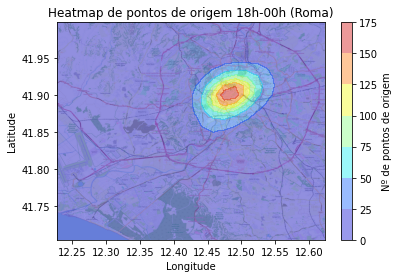

In [20]:
### Plota um heatmap das origens das trips
x = []
y = []

for i in range(len(posOrigem['long'])):
    if posDestino['long'][i] >= 12.20 and posDestino['long'][i] <= 12.63 and\
            posDestino['lat'][i] >= 41.70 and posDestino['lat'][i] < 42:
        x.append(posOrigem['long'][i])
        y.append(posOrigem['lat'][i])

x = np.array(x)
y = np.array(y)

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plot = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, alpha=0.4)
fig.colorbar(plot,label="Nº de pontos de origem")

ax.set_title('Heatmap de pontos de origem 18h-00h (Roma)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmap_all_Roma1b.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
plt.savefig(path+"/img/mapaCalorOrigem_Roma3b_18To0.png", dpi=300, transparent=False, facecolor='white')

In [ ]:
### Plota um histograma2D das origens das trips
x = []
y = []

for i in range(len(posOrigem['long'])):
    if posOrigem['long'][i] > 12.2 and posOrigem['long'][i] < 12.7 and\
            posOrigem['lat'][i] > 41.7 and posOrigem['lat'][i] < 42.1:
        x.append(posOrigem['long'][i])
        y.append(posOrigem['lat'][i])

x = np.array(x)
y = np.array(y)

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plt.hist2d(x,y,bins=(50,50),cmap=plt.cm.jet,alpha=0.6)

ax.set_title('Histograma - Pontos de Origem 18h-00h (Roma)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmap_all_Roma1.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

plt.colorbar(label="Nº de pontos de origem")
plt.savefig(path+"/img/hist2d_orig_Roma50x50_18To0.png", dpi=300, transparent=False, facecolor='white')
plt.show()